image 1/1 C:\Users\boped\Documents\GitHub\Bird-Recognition\dataset_parts\Carduelis_carduelis\235.jpg: 640x448 1 bird, 59.0ms


Speed: 2.7ms preprocess, 59.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


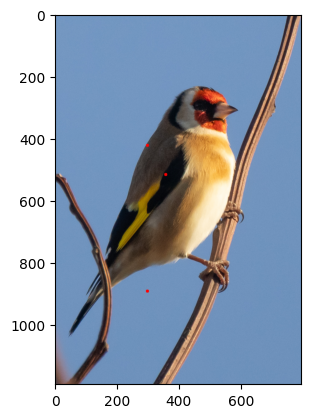

NameError: name 'sam' is not defined

In [ ]:
from segment_anything import SamPredictor
import numpy as np
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 1. First detect the whole bird with YOLO
bird_detector = YOLO('yolov8n.pt')  # Pretrained on COCO (includes birds)
results = bird_detector(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")
x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()  # Bird bounding box

# 2. Calculate SMART points within the detected bird
bird_width = x2 - x1
bird_height = y2 - y1

input_points = np.array([
    [x1 + 0.5 * bird_width, y1 + 0.2 * bird_height],  # Head (center-top of bird)
    [x1 + 0.6 * bird_width, y1 + 0.3 * bird_height],  # Beak (right of head)
    [x1 + 0.5 * bird_width, y1 + 0.7 * bird_height]   # Wing (lower center)
])

# 3. Visualize the points (for debugging)
img = cv2.imread(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")
for point in input_points:
    cv2.circle(img, tuple(point.astype(int)), 5, (0,0,255), -1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. Run SAM with these dynamic points
predictor = SamPredictor(sam)
predictor.set_image(img)
masks, scores, _ = predictor.predict(
    point_coords=input_points,
    point_labels=np.array([1, 1, 1]),  # 1=foreground
    multimask_output=False
)

print(scores)

# Only accept if confidence is high enough
if scores[0] > confidence_threshold:  # Adjust threshold as needed
    detected_parts[part_name] = masks[0]

# 5. Save the best mask for each part
for i, mask in enumerate(masks):
    cv2.imwrite(f"part_{['head','beak','wing'][i]}.png", mask * 255)

In [ ]:
# 2. Imports and model initialization
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Download from https://github.com/facebookresearch/segment-anything#model-checkpoints
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt')  # Auto-downloads pretrained weights

# 3. Detection function with visualization
def detect_bird_parts(img_path):
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if len(results[0].boxes) == 0:
        print("No birds detected!")
        return
    
    # Get largest bird detection
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()
    
    parts = {
        'head': [x1 + 0.5*(x2-x1), y1 + 0.2*(y2-y1)],
        'beak': [x1 + 0.6*(x2-x1), y1 + 0.3*(y2-y1)], 
        'wing': [x1 + 0.5*(x2-x1), y1 + 0.7*(y2-y1)]
    }
    
    # Visualize points
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.scatter(parts[:,0], parts[:,1], c='red', s=100, marker='o')
    plt.title("SAM Input Points")
    plt.axis('off')
    plt.show()
    
    # Run SAM
    predictor.set_image(img_rgb)
    
    detected_parts = {}
        
    for part_name, point in parts.items():            
        masks, scores, _ = predictor.predict(
            point_coords=parts,
            point_labels=np.array([1, 1, 1]),  # 1=foreground
            multimask_output=False
        )
        
        print(scores)
        
        
        
        # Only accept if confidence is high enough
        if scores[0] > 0.3:  # Adjust threshold as needed
            detected_parts[part_name] = masks[0]
    
    # Display results
    plt.figure(figsize=(15, 5))
    for i, detected_parts in enumerate(detected_parts):
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        show_mask(mask, plt.gca())
        plt.title(f"{['Head','Beak','Wing'][i]}\nScore: {score:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Helper function to overlay masks
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# 4. Run detection
detect_bird_parts(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")# 2. Imports and model initialization


0: 640x448 2 birds, 222.4ms
Speed: 6.3ms preprocess, 222.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


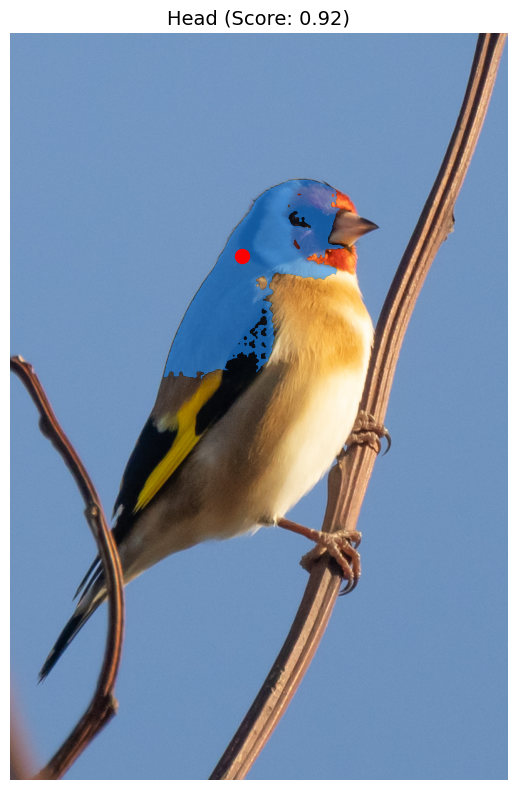

Head detection score: 0.92


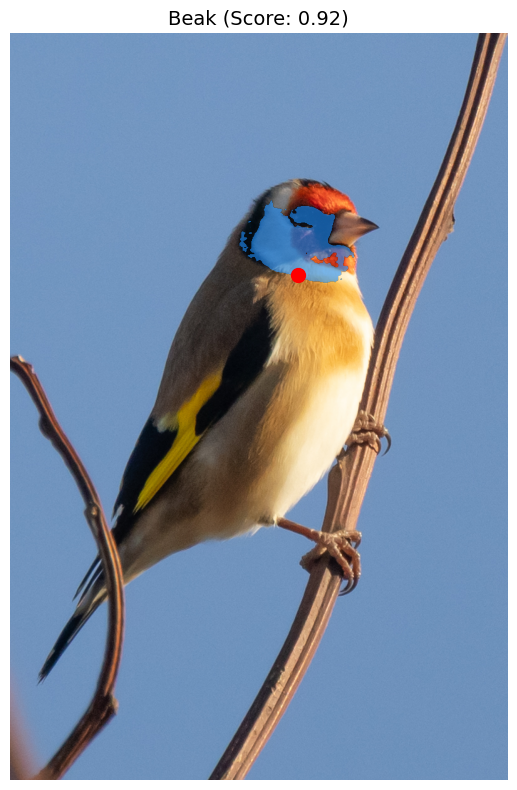

Beak detection score: 0.92


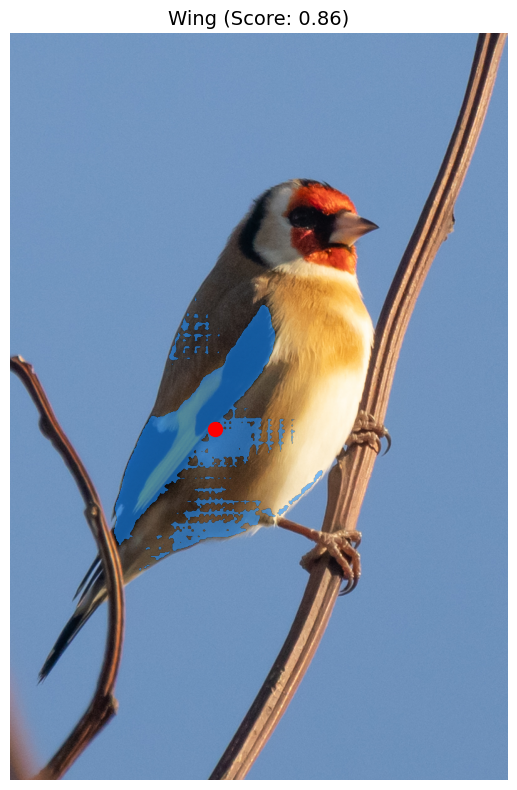

Wing detection score: 0.86


In [5]:

from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)  # Auto-downloads pretrained weights

# Helper function to overlay masks
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def detect_bird_parts(img_path, confidence_threshold=0.7):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if len(results[0].boxes) == 0:
        print("No birds detected!")
        return
    
    # Get largest bird detection
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()
    bird_width = x2 - x1
    bird_height = y2 - y1
    
    # Define part locations with spatial constraints
    parts_config = {
        'head': {
            'rel_pos': [0.5, 0.2],
            'size_factor': 0.3,
            'negative_points': [[0.5, 0.6]]  # Avoid body
        },
        'beak': {
            'rel_pos': [0.7, 0.25],
            'size_factor': 0.15,
            'negative_points': [[0.4, 0.3]]  # Avoid head
        },
        'wing': {
            'rel_pos': [0.4, 0.65],
            'size_factor': 0.4,
            'negative_points': [[0.5, 0.3]]  # Avoid head
        }
    }
    
    # Process each part
    predictor.set_image(img_rgb)
    detected_parts = {}
    
    for part_name, config in parts_config.items():
        # Calculate absolute coordinates
        abs_x = x1 + config['rel_pos'][0] * bird_width
        abs_y = y1 + config['rel_pos'][1] * bird_height
        point = np.array([[abs_x, abs_y]])
        
        # Create negative points (background)
        neg_points = np.array([
            [x1 + p[0] * bird_width, y1 + p[1] * bird_height]
            for p in config['negative_points']
        ]) if config['negative_points'] else None
        
        # Combine all points
        all_points = point
        all_labels = np.array([1])  # 1=foreground
        
        if neg_points is not None:
            all_points = np.concatenate([all_points, neg_points])
            all_labels = np.concatenate([all_labels, np.zeros(len(neg_points))])
        
        # Get masks with spatial constraints
        masks, scores, _ = predictor.predict(
            point_coords=all_points,
            point_labels=all_labels,
            multimask_output=True,
            box=np.array([
                max(0, abs_x - bird_width * config['size_factor']),
                max(0, abs_y - bird_height * config['size_factor']),
                min(width, abs_x + bird_width * config['size_factor']),
                min(height, abs_y + bird_height * config['size_factor'])
            ]) if config['size_factor'] else None
        )
        
        # Store best mask if above threshold
        best_idx = np.argmax(scores)
        if scores[best_idx] > confidence_threshold:
            detected_parts[part_name] = {
                'mask': masks[best_idx],
                'score': scores[best_idx],
                'point': point[0]
            }
    
    # Display each detected part individually
    for part_name, result in detected_parts.items():
        plt.figure(figsize=(8, 8))
        
        # Show original image with mask overlay
        plt.imshow(img_rgb)
        show_mask(result['mask'], plt.gca())
        plt.scatter(result['point'][0], result['point'][1], c='red', s=100)
        
        # Add title with score
        plt.title(f"{part_name.capitalize()} (Score: {result['score']:.2f})", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print score in console
        print(f"{part_name.capitalize()} detection score: {result['score']:.2f}")
    
    # If no parts detected
    if not detected_parts:
        print("No parts detected above confidence threshold!")
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.title("No parts detected", fontsize=14)
        plt.axis('off')
        plt.show()

# 4. Run detection
detect_bird_parts(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x448 2 birds, 162.9ms
Speed: 7.1ms preprocess, 162.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


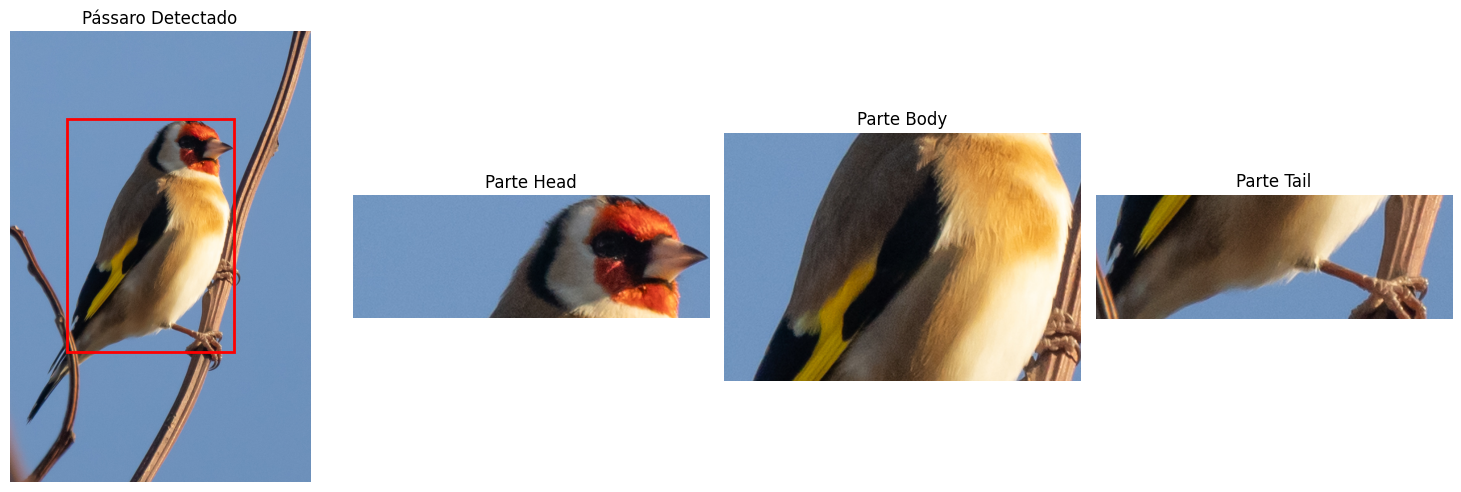

In [6]:
def detect_and_divide_bird(img_path, show_grid=True):
    # Carregar imagem
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erro: Não foi possível ler a imagem {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detectar pássaro com YOLO
    results = bird_detector(img_rgb)
    if len(results[0].boxes) == 0:
        print("Nenhum pássaro detectado!")
        return
    
    # Obter a maior detecção
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()
    
    # Dividir a região do pássaro em 3 partes verticais
    height = y2 - y1
    section_height = height / 3
    
    # Divisão com proporções variáveis (ex: 25%-50%-25%)
    sections = {
        'head': (x1, y1, x2, y1 + 0.25*(y2-y1)),
        'body': (x1, y1 + 0.25*(y2-y1), x2, y1 + 0.75*(y2-y1)),
        'tail': (x1, y1 + 0.75*(y2-y1), x2, y2)
    }
    
    # Mostrar resultados
    plt.figure(figsize=(15, 5))
    
    # Imagem original com bounding box
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                         fill=False, edgecolor='red', linewidth=2))
    plt.title("Pássaro Detectado")
    plt.axis('off')
    
    # Mostrar cada seção individualmente
    for i, (name, (sx1, sy1, sx2, sy2)) in enumerate(sections.items()):
        plt.subplot(1, 4, i+2)
        section = img_rgb[int(sy1):int(sy2), int(sx1):int(sx2)]
        plt.imshow(section)
        
        if show_grid:
            # Adicionar grid para visualização
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.grid(color='white', linestyle='-', linewidth=0.5)
            plt.gca().set_xticks(np.arange(-0.5, section.shape[1], 1), minor=True)
            plt.gca().set_yticks(np.arange(-0.5, section.shape[0], 1), minor=True)
        
        plt.title(f"Parte {name.capitalize()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Exemplo de uso
detect_and_divide_bird(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x448 2 birds, 74.8ms
Speed: 2.7ms preprocess, 74.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


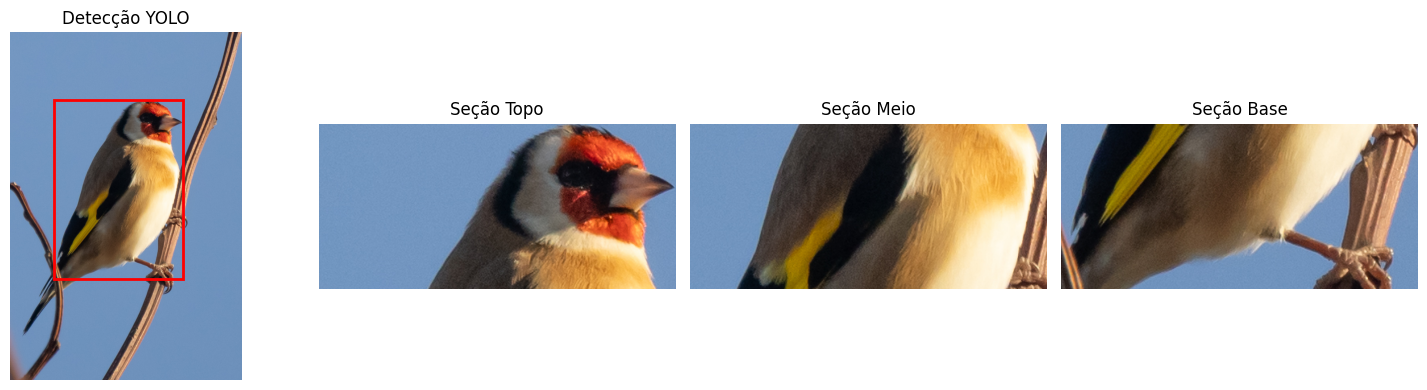

In [8]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Inicialização do YOLO (uma única vez)
bird_detector = YOLO('yolov8n.pt')  # Modelo pré-treinado que já inclui aves

def divide_bird_sections(img_path):
    # 2. Detecção do pássaro (YOLO)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = bird_detector(img_rgb)
    
    if not results[0].boxes:
        print("⚠️ Nenhum pássaro detectado!")
        return

    # 3. Obter coordenadas da caixa delimitadora
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
    
    # 4. Divisão em 3 seções verticais iguais
    height = y2 - y1
    sections = {
        'Topo':    (x1, y1,             x2, y1 + int(height/3)),
        'Meio':    (x1, y1 + int(height/3), x2, y1 + int(2*height/3)),
        'Base':    (x1, y1 + int(2*height/3), x2, y2)
    }

    # 5. Visualização
    plt.figure(figsize=(15, 4))
    
    # Imagem original com bounding box
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                         fill=False, edgecolor='red', linewidth=2))
    plt.title("Detecção YOLO")
    plt.axis('off')

    # Mostrar cada seção
    for i, (name, (sx1, sy1, sx2, sy2)) in enumerate(sections.items()):
        plt.subplot(1, 4, i+2)
        section = img_rgb[sy1:sy2, sx1:sx2]
        plt.imshow(section)
        plt.title(f"Seção {name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Exemplo de uso
divide_bird_sections(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x448 2 birds, 967.0ms
Speed: 3.7ms preprocess, 967.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


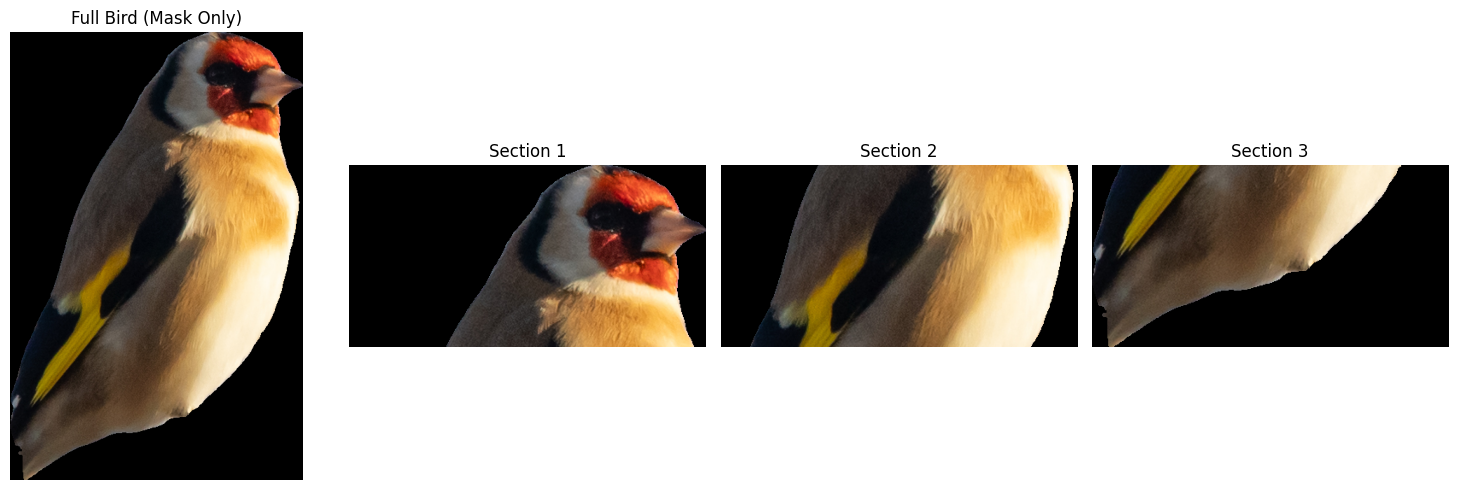

In [15]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)

def divide_bird_only(img_path):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if not results[0].boxes:
        print("No bird detected!")
        return
    
    # Get precise bird mask using SAM
    x1, y1, x2, y2 = map(int, results[0].boxes.xyxy[0].cpu().numpy())
    predictor.set_image(img_rgb)
    masks, _, _ = predictor.predict(
        box=np.array([x1, y1, x2, y2]),
        multimask_output=False
    )
    bird_mask = masks[0]
    
    # Get only bird pixels (remove background)
    isolated_bird = np.zeros_like(img_rgb)
    isolated_bird[bird_mask] = img_rgb[bird_mask]
    
    # Find bird boundaries in mask
    y_coords, x_coords = np.where(bird_mask)
    y_min, y_max = y_coords.min(), y_coords.max()
    x_min, x_max = x_coords.min(), x_coords.max()
    bird_height = y_max - y_min
    
    # Divide into 3 vertical sections using MASK coordinates
    section_height = bird_height // 3
    sections = []
    
    for i in range(3):
        # Create section mask
        section_mask = np.zeros_like(bird_mask)
        y_start = y_min + i * section_height
        y_end = y_min + (i+1) * section_height
        section_mask[y_start:y_end, x_min:x_max] = bird_mask[y_start:y_end, x_min:x_max]
        
        # Apply mask and crop
        section = np.zeros_like(img_rgb)
        section[section_mask] = img_rgb[section_mask]
        section = section[y_start:y_end, x_min:x_max]
        sections.append(section)
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    # Full isolated bird
    plt.subplot(1, 4, 1)
    plt.imshow(isolated_bird[y_min:y_max, x_min:x_max])
    plt.title("Full Bird (Mask Only)")
    plt.axis('off')
    
    # Show each section
    for i, section in enumerate(sections):
        plt.subplot(1, 4, i+2)
        plt.imshow(section)
        plt.title(f"Section {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
divide_bird_only(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x608 2 birds, 1234.7ms
Speed: 123.8ms preprocess, 1234.7ms inference, 19.7ms postprocess per image at shape (1, 3, 640, 608)


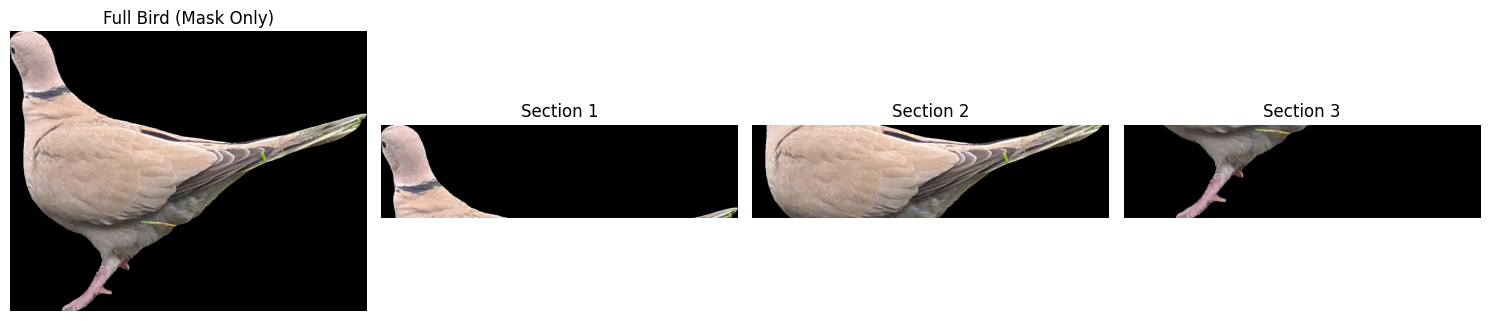

In [17]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)

def divide_bird_only(img_path):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if not results[0].boxes:
        print("No bird detected!")
        return
    
    # Get precise bird mask using SAM
    x1, y1, x2, y2 = map(int, results[0].boxes.xyxy[0].cpu().numpy())
    predictor.set_image(img_rgb)
    masks, _, _ = predictor.predict(
        box=np.array([x1, y1, x2, y2]),
        multimask_output=False
    )
    bird_mask = masks[0]
    
    # Get only bird pixels (remove background)
    isolated_bird = np.zeros_like(img_rgb)
    isolated_bird[bird_mask] = img_rgb[bird_mask]
    
    # Find bird boundaries in mask
    y_coords, x_coords = np.where(bird_mask)
    y_min, y_max = y_coords.min(), y_coords.max()
    x_min, x_max = x_coords.min(), x_coords.max()
    bird_height = y_max - y_min
    
    # Divide into 3 vertical sections using MASK coordinates
    section_height = bird_height // 3
    sections = []
    
    for i in range(3):
        # Create section mask
        section_mask = np.zeros_like(bird_mask)
        y_start = y_min + i * section_height
        y_end = y_min + (i+1) * section_height
        section_mask[y_start:y_end, x_min:x_max] = bird_mask[y_start:y_end, x_min:x_max]
        
        # Apply mask and crop
        section = np.zeros_like(img_rgb)
        section[section_mask] = img_rgb[section_mask]
        section = section[y_start:y_end, x_min:x_max]
        sections.append(section)
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    # Full isolated bird
    plt.subplot(1, 4, 1)
    plt.imshow(isolated_bird[y_min:y_max, x_min:x_max])
    plt.title("Full Bird (Mask Only)")
    plt.axis('off')
    
    # Show each section
    for i, section in enumerate(sections):
        plt.subplot(1, 4, i+2)
        plt.imshow(section)
        plt.title(f"Section {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
divide_bird_only(".\\dataset_parts\\Streptopelia_decaocto\\58.jpg")


YOLO

0: 640x480 2 birds, 1 bear, 120.9ms
Speed: 3.6ms preprocess, 120.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)
tensor([14., 21., 14.])
['bird', 'bear', 'bird']
SAM
PLOT


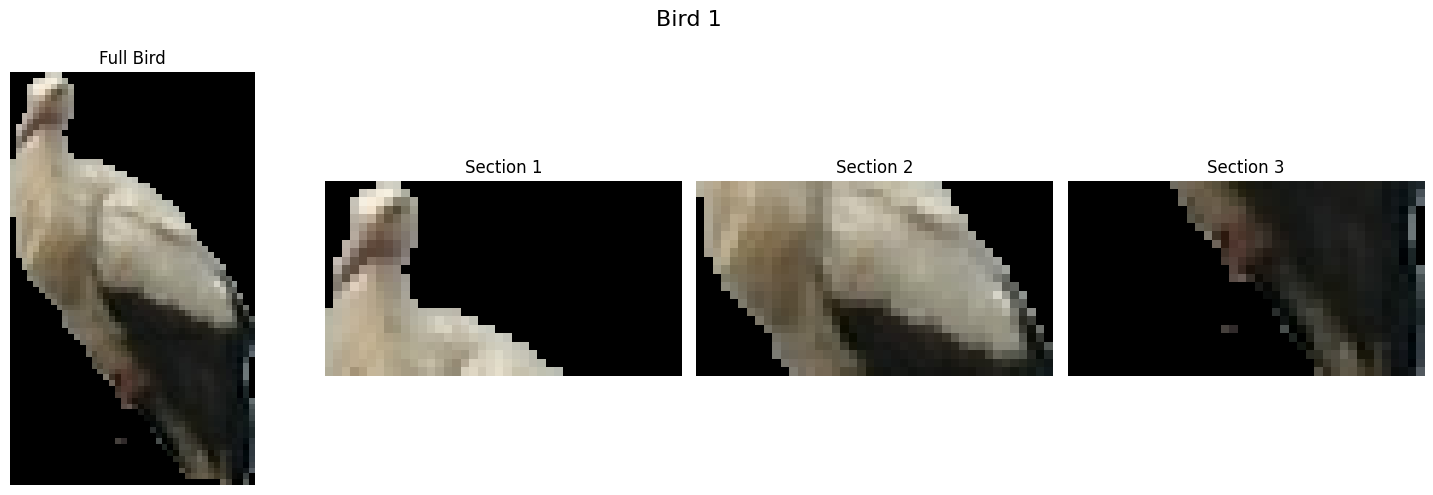

['bird', 'bear', 'bird']
['bird', 'bear', 'bird']
SAM
PLOT


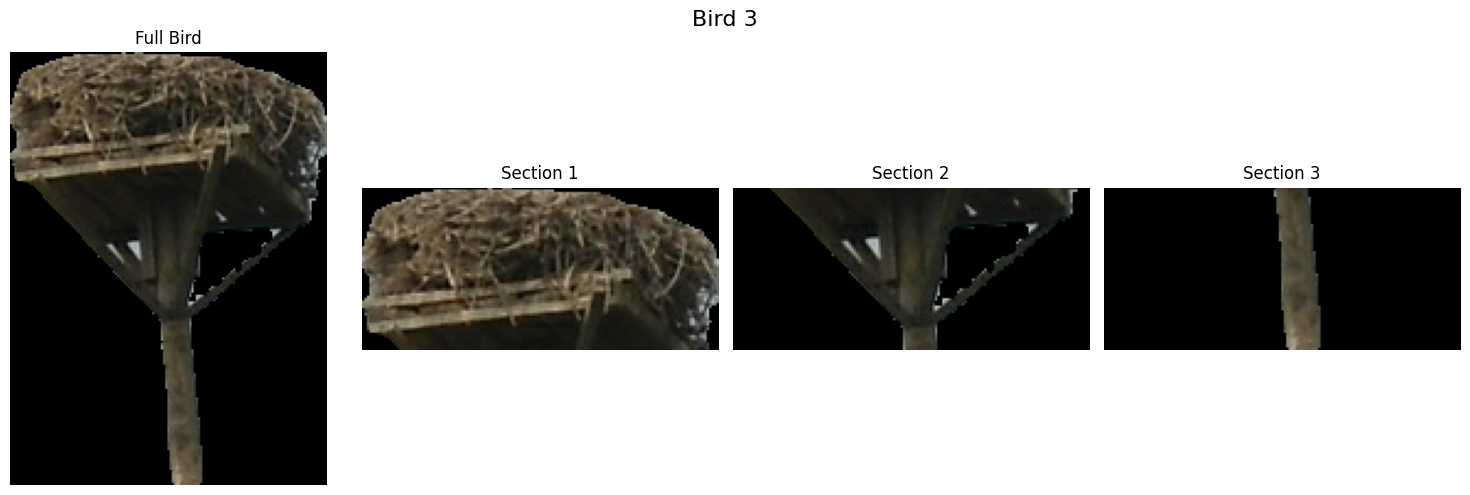

In [17]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize models
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)

def process_multiple_birds(img_path):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect all birds with YOLO
    print("YOLO")
    results = bird_detector(img_rgb)
    
    if not results[0].boxes:
        print("No birds detected!")
        return


    print(results[0].boxes.cls)
    names = [results[0].names[cls.item()] for cls in results[0].boxes.cls.int()]
    
    # Process each bird individually
    for bird_idx, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)

        print(names)
        if results[0].boxes.cls.int()[bird_idx] != 14:
            continue
        
        # Get precise bird mask using SAM
        print("SAM")
        predictor.set_image(img_rgb)
        masks, _, _ = predictor.predict(
            box=np.array([x1, y1, x2, y2]),
            multimask_output=False
        )
        bird_mask = masks[0]
        
        # Isolate current bird
        isolated_bird = np.zeros_like(img_rgb)
        isolated_bird[bird_mask] = img_rgb[bird_mask]
        
        # Find bird boundaries in mask
        y_coords, x_coords = np.where(bird_mask)
        if len(y_coords) == 0 or len(x_coords) == 0:
            continue
            
        y_min, y_max = y_coords.min(), y_coords.max()
        x_min, x_max = x_coords.min(), x_coords.max()
        bird_height = y_max - y_min
        
        # Skip if bird is too small
        if bird_height < 20:
            continue
            
        # Divide into 3 vertical sections
        section_height = bird_height // 3
        sections = []
        
        for i in range(3):
            # Create section mask
            section_mask = np.zeros_like(bird_mask)
            y_start = y_min + i * section_height
            y_end = y_min + (i+1) * section_height
            section_mask[y_start:y_end, x_min:x_max] = bird_mask[y_start:y_end, x_min:x_max]
            
            # Apply mask and crop
            section = np.zeros_like(img_rgb)
            section[section_mask] = img_rgb[section_mask]
            section = section[y_start:y_end, x_min:x_max]
            sections.append(section)

        print("PLOT")
        
        # Display results for this bird
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Bird {bird_idx+1}", fontsize=16)
        
        # Full isolated bird
        plt.subplot(1, 4, 1)
        plt.imshow(isolated_bird[y_min:y_max, x_min:x_max])
        plt.title("Full Bird")
        plt.axis('off')
        
        # Show each section
        for i, section in enumerate(sections):
            plt.subplot(1, 4, i+2)
            plt.imshow(section)
            plt.title(f"Section {i+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage
process_multiple_birds("dataset_parts\\normal_dataset\\Ciconia_ciconia\\0b6dae6a-f29b-488f-af4b-5643db49cd5b.jpg")

In [11]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import h5py
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms



species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

DATA_DIR = 'dataset_parts\\normal_dataset' 
OUTPUT_FILE = 'bird_dataset_segmented_1304_pytorch.h5'  # Output HDF5 file
IMG_SIZE = (224, 224)             # Standard size for CNNs
TEST_SIZE = 0.1                   # Test set proportion
COMPRESSION = 'gzip'              # Compression type
COMPRESSION_LEVEL = 7             # Compression level (1-9)

train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)

images = []
labels = []

for idx, specie in enumerate(species):
    print("Specie:"+ specie)
    specie_dir = DATA_DIR + '\\' + specie
        
    for img_name in os.listdir(specie_dir):
        img_path = os.path.join(specie_dir, img_name)
            
        try:
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error loading image: {img_path}")
                continue
                
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            
            
            # Detect all birds with YOLO
            results = bird_detector(img_rgb, verbose=False)
            if not results[0].boxes:
                print(f"No birds detected: {img_path}")
                continue

            names = [results[0].names[cls.item()] for cls in results[0].boxes.cls.int()]
            
            # Process each bird individually
            for bird_idx, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
                
                if results[0].boxes.cls.int()[bird_idx] != 14:
                    continue
                
                x1, y1, x2, y2 = map(int, box)
                
                # Get precise bird mask using SAM
                predictor.set_image(img_rgb)
                masks, _, _ = predictor.predict(
                    box=np.array([x1, y1, x2, y2]),
                    multimask_output=False
                )
                bird_mask = masks[0]
                
                # Isolate current bird
                isolated_bird = np.zeros_like(img_rgb)
                isolated_bird[bird_mask] = img_rgb[bird_mask]
                
                # Find bird boundaries in mask
                y_coords, x_coords = np.where(bird_mask)
                if len(y_coords) == 0 or len(x_coords) == 0:
                    continue
                    
                y_min, y_max = y_coords.min(), y_coords.max()
                x_min, x_max = x_coords.min(), x_coords.max()
                bird_height = y_max - y_min
                
                # Skip if bird is too small
                if bird_height < 20:
                    continue
                    
                # Divide into 3 vertical sections
                section_height = bird_height // 3
                sections = []
                
                for i in range(3):
                    # Create section mask
                    section_mask = np.zeros_like(bird_mask)
                    y_start = y_min + i * section_height
                    y_end = y_min + (i+1) * section_height
                    section_mask[y_start:y_end, x_min:x_max] = bird_mask[y_start:y_end, x_min:x_max]
                    
                    # Apply mask and crop
                    section = np.zeros_like(img_rgb)
                    section[section_mask] = img_rgb[section_mask]
                    section = section[y_start:y_end, x_min:x_max]
                    images.append(np.array(section))  # Keep as uint8 [0,255]
                    labels.append(idx)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Load and preprocess images
print("Loading and preprocessing images...")
X = images
y = np.array(labels)


cuda
Specie:Ciconia_ciconia
No birds detected: dataset_parts\normal_dataset\Ciconia_ciconia\114.jpg
No birds detected: dataset_parts\normal_dataset\Ciconia_ciconia\185.jpg
No birds detected: dataset_parts\normal_dataset\Ciconia_ciconia\20.jpg
No birds detected: dataset_parts\normal_dataset\Ciconia_ciconia\4d8e2927-707e-4651-91b5-4bd1c4fdbaf1.jpg
No birds detected: dataset_parts\normal_dataset\Ciconia_ciconia\98.jpg
Specie:Columba_livia
No birds detected: dataset_parts\normal_dataset\Columba_livia\17.jpg
Specie:Streptopelia_decaocto
No birds detected: dataset_parts\normal_dataset\Streptopelia_decaocto\107.jpg
No birds detected: dataset_parts\normal_dataset\Streptopelia_decaocto\162.jpg
No birds detected: dataset_parts\normal_dataset\Streptopelia_decaocto\228.jpg
Specie:Emberiza_calandra
No birds detected: dataset_parts\normal_dataset\Emberiza_calandra\17.jpg
No birds detected: dataset_parts\normal_dataset\Emberiza_calandra\193.jpg
No birds detected: dataset_parts\normal_dataset\Emberiza

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6898,) + inhomogeneous part.

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

def apply_transforms(images, transform):
    transformed = []
    for img in images:
        pil_img = Image.fromarray(img)
        transformed.append(transform(pil_img))
    return torch.stack(transformed)


# Load and preprocess images
print("Loading and preprocessing images...")
X = images
y = np.array(labels)

print(len(images))

X_t_tensor = apply_transforms(X, train_transforms)

y_tensor = torch.from_numpy(y).long()



# Save data to HDF5 file
print(f"Saving data to {OUTPUT_FILE}...")
with h5py.File(OUTPUT_FILE, 'w') as hf:
    # Save datasets with compression
    hf.create_dataset('X', data=X_t_tensor, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
    hf.create_dataset('y', data=y_tensor, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

    
    # Save metadata
    hf.attrs['species'] = np.array(species, dtype=h5py.string_dtype())
    hf.attrs['image_size'] = IMG_SIZE

print("Process completed successfully!")
print(f"Data saved to {OUTPUT_FILE} with {COMPRESSION} compression level {COMPRESSION_LEVEL}")

Loading and preprocessing images...
7665
Saving data to bird_dataset_segmented_1304_pytorch.h5...


In [1]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import h5py
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms


with h5py.File('bird_dataset_segmented_1304_pytorch.h5', 'r') as hf:
    X_t_tensor = torch.from_numpy(hf['X'][:])
    y_tensor = torch.from_numpy(hf['y'][:])
    
print(X_t_tensor.shape)
print(y_tensor.shape)

dataset = TensorDataset(X_t_tensor, y_tensor)

torch.Size([7665, 3, 224, 224])
torch.Size([7665])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


X_t_tensor shape: torch.Size([7665, 3, 224, 224])
y_tensor shape: torch.Size([7665])


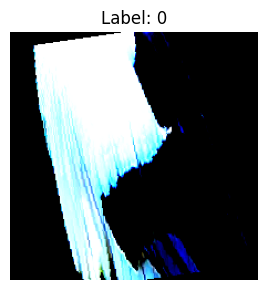

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your images are in shape (N, C, H, W) or (N, H, W, C)
# Let's check the shape first
print("X_t_tensor shape:", X_t_tensor.shape)
print("y_tensor shape:", y_tensor.shape)


# Create a figure
plt.figure(figsize=(15, 3))


# Get the image and label
image = X_t_tensor[301]
label = y_tensor[301]


    


    # If the image is in PyTorch format (C, H, W), we need to permute it for matplotlib
if len(image.shape) == 3 and image.shape[0] in [1, 3]:  # Check if channels first
    image = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    
    
plt.imshow(image.numpy(), cmap='gray' if len(image.shape) == 2 else None)
plt.title(f"Label: {label.item()}")
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, top_k_accuracy_score


from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

from datetime import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import h5py
from PIL import Image

# Configurações
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
NUM_CLASSES = 11
MODEL_SAVE_DIR = 'saved_models'
RESULTS_DIR = 'hyperparameter_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Hiperparâmetros para testar
HYPERPARAMS = {
    'learning_rate': [1e-3, 3e-4, 1e-4],                # Balanced range for Adam/SGD
    'batch_size': [32],                             # Fits most GPUs, tradeoff between speed & stability
    'optimizer': ['adam','sgd'],                        # Adam is robust; we can add SGD later if needed
    'weight_decay': [0, 1e-4],                          # Regularization; 1e-4 is standard
    'dropout_rate': [0.2, 0.5],                         # Typical for classification; prevents overfitting
    'model_name': ['efficientnet']          # Two strong baselines
}

# Função para criar modelo com hiperparâmetros específicos
def get_model(config):
    model_name = config['model_name']
    dropout_rate = config['dropout_rate']
    
    if model_name == 'efficientnet':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Freeze all layers first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze last layers
        for param in model.features[-3:].parameters():
            param.requires_grad = True
        # Modify classifier
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(model.classifier[1].in_features, NUM_CLASSES))
    
    return model.to(DEVICE)


def train_and_evaluate(model, train_loader, val_loader, config, max_epochs=25):
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                               lr=config['learning_rate'],
                               weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(),
                              lr=config['learning_rate'],
                              momentum=0.9,
                              weight_decay=config['weight_decay'])

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config['learning_rate'],
        steps_per_epoch=len(train_loader),
        epochs=max_epochs,
        pct_start=0.3,
        anneal_strategy='cos'
    )

    best_macro_f1 = 0.0
    best_acc = 0.0
    best_macro_auprc = 0.0
    best_top3_acc = 0.0
    

    for epoch in range(max_epochs):
        print(f"Epoch: {epoch+1}/{max_epochs}")
        
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        all_preds = []
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(probs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        all_probs_np = np.array(all_probs)
        all_labels_np = np.array(all_labels)
        all_preds_np = np.array(all_preds)

        macro_f1 = f1_score(all_labels_np, all_preds_np, average='macro')
        acc = accuracy_score(all_labels_np, all_preds_np)
        macro_auprc = average_precision_score(
            np.eye(NUM_CLASSES)[all_labels_np], all_probs_np, average='macro'
        )
        top3_acc = top_k_accuracy_score(all_labels_np, all_probs_np, k=3)

        

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            
        if acc > best_acc:
            best_acc = acc

        if macro_auprc > best_macro_auprc:
            best_macro_auprc = macro_auprc
            
        if top3_acc > best_top3_acc:
            best_top3_acc = top3_acc
            best_model_state = model.state_dict()
            


    return best_macro_f1, best_acc, best_macro_auprc, best_top3_acc, best_model_state


def hyperparameter_search(dataset, num_folds=3):
    from itertools import product
    keys, values = zip(*HYPERPARAMS.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    
    
    results = []
    
    for config in combinations:
        print(f"\nTesting config: {config}")
        
        kfold = KFold(n_splits=num_folds, shuffle=True)
        fold_metrics = {'f1': [], 'acc': [], 'auprc': [], 'top3': []}
        
        for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
            print(f"\nFold {fold+1}/{num_folds}")
            
            # Criar data loaders para este fold
            train_subsampler = SubsetRandomSampler(train_ids)
            val_subsampler = SubsetRandomSampler(val_ids)
            
            train_loader = DataLoader(
                dataset,
                batch_size=config['batch_size'],
                sampler=train_subsampler)
            
            val_loader = DataLoader(
                dataset,
                batch_size=config['batch_size'],
                sampler=val_subsampler)
            
            # Criar e treinar modelo
            model = get_model(config)
            best_f1, best_acc, best_auprc, best_top3 = train_and_evaluate(model, train_loader, val_loader, config)
            
            fold_metrics['f1'].append(best_f1)
            fold_metrics['acc'].append(best_acc)
            fold_metrics['auprc'].append(best_auprc)
            fold_metrics['top3'].append(best_top3)
        
        # Calcular médias entre folds
        mean_f1 = np.mean(fold_metrics['f1'])
        std_f1 = np.std(fold_metrics['f1'])
        mean_acc = np.mean(fold_metrics['acc'])
        std_acc = np.std(fold_metrics['acc'])
        
        
        # Registrar resultados
        result = {
            'config': str(config),
            'mean_f1': np.mean(fold_metrics['f1']),
            'std_f1': np.std(fold_metrics['f1']),
            'mean_acc': np.mean(fold_metrics['acc']),
            'std_acc': np.std(fold_metrics['acc']),
            'mean_auprc': np.mean(fold_metrics['auprc']),
            'std_auprc': np.std(fold_metrics['auprc']),
            'mean_top3': np.mean(fold_metrics['top3']),
            'std_top3': np.std(fold_metrics['top3'])
        }

        results.append(result)
        
        print(f"\nResults for config {config}:")
        print(f"F1-score: {mean_f1:.4f} ± {std_f1:.4f}")
        print(f"Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    
    # Salvar resultados em CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df = pd.DataFrame(results)
    results_file = os.path.join(RESULTS_DIR, f'hyperparameter_results_{timestamp}.csv')
    results_df.to_csv(results_file, index=False)
    
    return results_df

with h5py.File('bird_dataset_segmented_1304_pytorch.h5', 'r') as hf:
    X_t_tensor = torch.from_numpy(hf['X'][:])
    y_tensor = torch.from_numpy(hf['y'][:])
    
print(X_t_tensor.shape)
print(y_tensor.shape)

dataset = TensorDataset(X_t_tensor, y_tensor)

# Executar a busca por hiperparâmetros
results = hyperparameter_search(dataset, num_folds=3)


cuda
torch.Size([7665, 3, 224, 224])
torch.Size([7665])

Testing config: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0, 'dropout_rate': 0.2, 'model_name': 'efficientnet'}

Fold 1/3
Epoch: 1/25
Epoch: 2/25
Epoch: 3/25
Epoch: 4/25
Epoch: 5/25
Epoch: 6/25
Epoch: 7/25
Epoch: 8/25
Epoch: 9/25
Epoch: 10/25
Epoch: 11/25
Epoch: 12/25
Epoch: 13/25
Epoch: 14/25
Epoch: 15/25
Epoch: 16/25
Epoch: 17/25
Epoch: 18/25
Epoch: 19/25
Epoch: 20/25
Epoch: 21/25
Epoch: 22/25
Epoch: 23/25
Epoch: 24/25
Epoch: 25/25

Fold 2/3
Epoch: 1/25
Epoch: 2/25
Epoch: 3/25
Epoch: 4/25
Epoch: 5/25
Epoch: 6/25
Epoch: 7/25
Epoch: 8/25
Epoch: 9/25
Epoch: 10/25
Epoch: 11/25
Epoch: 12/25
Epoch: 13/25
Epoch: 14/25
Epoch: 15/25
Epoch: 16/25
Epoch: 17/25
Epoch: 18/25
Epoch: 19/25
Epoch: 20/25
Epoch: 21/25
Epoch: 22/25
Epoch: 23/25
Epoch: 24/25
Epoch: 25/25

Fold 3/3
Epoch: 1/25
Epoch: 2/25
Epoch: 3/25
Epoch: 4/25
Epoch: 5/25
Epoch: 6/25
Epoch: 7/25
Epoch: 8/25
Epoch: 9/25
Epoch: 10/25
Epoch: 11/

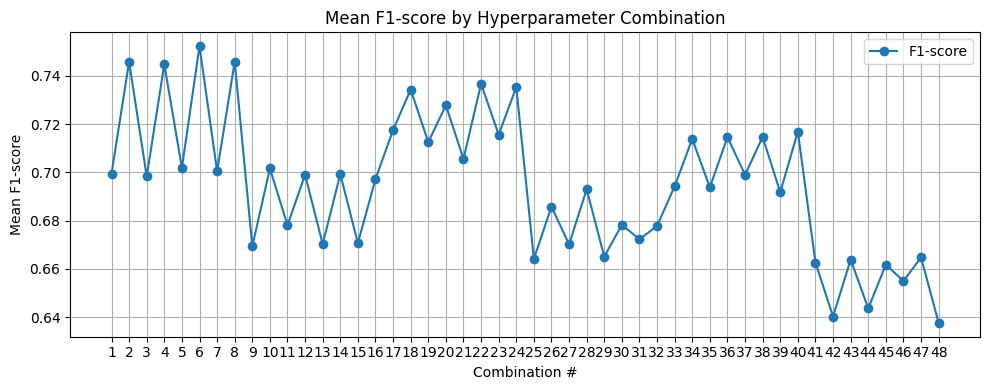

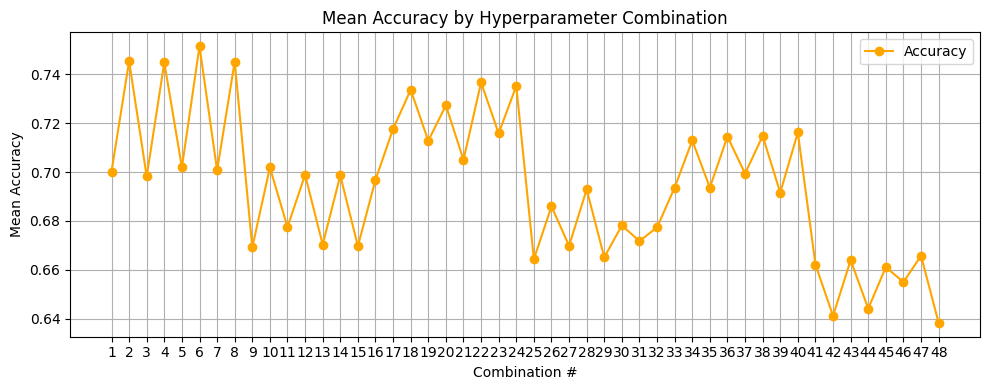

In [3]:
# Reload original dataframe to match user's description (no combo_id column, use index instead)
df_raw = pd.read_csv("hyperparameter_results/hyperparameter_results_20250419_133632.csv")

# Use index as combination number (1-based)
combo_ids = range(1, len(df_raw) + 1)

# Simple line plot using index as combo ID
plt.figure(figsize=(10, 4))
plt.plot(combo_ids, df_raw['mean_f1'], marker='o', linestyle='-', label='F1-score')
plt.xlabel('Combination #')
plt.ylabel('Mean F1-score')
plt.title('Mean F1-score by Hyperparameter Combination')
plt.grid(True)
plt.xticks(combo_ids)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(combo_ids, df_raw['mean_acc'], marker='o', linestyle='-', color='orange', label='Accuracy')
plt.xlabel('Combination #')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy by Hyperparameter Combination')
plt.grid(True)
plt.xticks(combo_ids)
plt.legend()
plt.tight_layout()
plt.show()



In [14]:
#print(results.sort_values('mean_f1', ascending=False)[['config']].head(5))
top5_configs = results.sort_values('mean_f1', ascending=False).head(5)['config'].tolist()
for i, config in enumerate(top5_configs):
    print(f"Config {i+1}:\n{config}\n")

Config 1:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.0001, 'dropout_rate': 0.2, 'model_name': 'efficientnet'}

Config 2:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0, 'dropout_rate': 0.2, 'model_name': 'efficientnet'}

Config 3:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'model_name': 'efficientnet'}

Config 4:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0, 'dropout_rate': 0.5, 'model_name': 'efficientnet'}

Config 5:
{'learning_rate': 0.0003, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.0001, 'dropout_rate': 0.2, 'model_name': 'efficientnet'}



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

from datetime import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import h5py
from PIL import Image

# Configurações
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
NUM_CLASSES = 11
MODEL_SAVE_DIR = 'saved_models'
RESULTS_DIR = 'hyperparameter_results'
os.makedirs(RESULTS_DIR, exist_ok=True)


# Função para criar modelo com hiperparâmetros específicos
def get_model(config):
    model_name = config['model_name']
    dropout_rate = config['dropout_rate']
    
    if model_name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        # Freeze all layers first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze last layers
        for param in model.layer4.parameters():
            param.requires_grad = True
        # Modify classifier
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(model.fc.in_features, NUM_CLASSES))
        
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Freeze all layers first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze last layers
        for param in model.features[-3:].parameters():
            param.requires_grad = True
        # Modify classifier
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(model.classifier[1].in_features, NUM_CLASSES))
    
    return model.to(DEVICE)

def train_and_evaluate(model, train_loader, val_loader, config, patience=5, max_epochs=100):
    criterion = nn.CrossEntropyLoss()
    
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                               lr=config['learning_rate'],
                               weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(),
                              lr=config['learning_rate'],
                              momentum=0.9,
                              weight_decay=config['weight_decay'])
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    best_f1 = 0.0
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    epochs_no_improve = 0
    
    for epoch in range(max_epochs):
        print(f"Epoch: {epoch+1}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)
        
        train_loss /= len(train_loader.sampler)
        train_acc = train_correct.double() / len(train_loader.sampler)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader.sampler)
        val_acc = val_correct.double() / len(val_loader.sampler)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_acc.item())
        history['val_f1'].append(val_f1)
        
        scheduler.step(val_loss)
        
        # Check for improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_acc = val_acc.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return best_f1, best_acc, history


best_config = {
    'learning_rate': 3e-4,
    'batch_size': 32,
    'optimizer': 'adam',
    'weight_decay': 1e-4,
    'dropout_rate': 0.2,
    'model_name': 'resnet34'
}

with h5py.File('bird_dataset_segmented_1304_pytorch.h5', 'r') as hf:
    X_t_tensor = torch.from_numpy(hf['X'][:])
    y_tensor = torch.from_numpy(hf['y'][:])

# Split into train and validation sets
indices = list(range(len(X_t_tensor)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, shuffle=True, stratify=y_tensor)

dataset = TensorDataset(X_t_tensor, y_tensor)

train_loader = DataLoader(dataset, batch_size=best_config['batch_size'], sampler=SubsetRandomSampler(train_idx))
val_loader = DataLoader(dataset, batch_size=best_config['batch_size'], sampler=SubsetRandomSampler(val_idx))


model = get_model(best_config)
best_f1, best_acc, history = train_and_evaluate(model, train_loader, val_loader, best_config)

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Save model
model_path = os.path.join(MODEL_SAVE_DIR, 'best_bird_model.pth')
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")




cuda
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
No improvement for 1 epoch(s).
Epoch: 5
No improvement for 2 epoch(s).
Epoch: 6
Epoch: 7
Epoch: 8
No improvement for 1 epoch(s).
Epoch: 9
Epoch: 10
No improvement for 1 epoch(s).
Epoch: 11
No improvement for 2 epoch(s).
Epoch: 12
Epoch: 13
No improvement for 1 epoch(s).
Epoch: 14
No improvement for 2 epoch(s).
Epoch: 15
No improvement for 3 epoch(s).
Epoch: 16
No improvement for 4 epoch(s).
Epoch: 17
No improvement for 5 epoch(s).
Early stopping at epoch 17
Model saved to saved_models/best_bird_model.pth


NameError: name 'species' is not defined

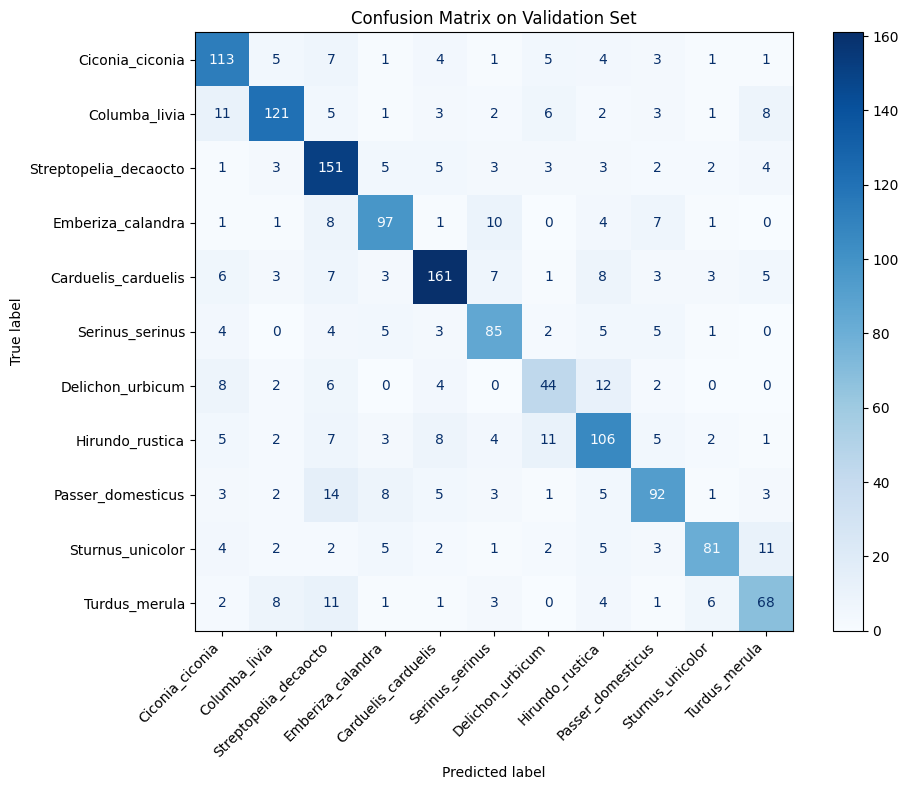

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

model = get_model(best_config)  # Use same config as during training
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(DEVICE)





# Get predictions from validation set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species)
disp.plot(cmap="Blues", values_format="d", ax=ax)

# Force correct positioning of labels
ax.set_xticks(np.arange(len(species)))
ax.set_xticklabels(species, rotation=45, ha='right')
ax.set_yticks(np.arange(len(species)))
ax.set_yticklabels(species)

plt.title("Confusion Matrix on Validation Set")
plt.tight_layout()
plt.show()


In [3]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_true: [ 0  1  2  3  4  5  6  7  8  9 10]
Unique values in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10]


In [6]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Use yolov8n for speed, yolov8s for accuracy
model.train(data='datasets/annotated_dataset/data.yaml', epochs=50, imgsz=640, batch=16)

New https://pypi.org/project/ultralytics/8.3.131 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.102  Python-3.12.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050, 8191MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/annotated_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning C:\Users\boped\Documents\GitHub\Bird-Recognition\datasets\annotated_dataset\labels\train.cache... 87 im
val: Scanning C:\Users\boped\Documents\GitHub\Bird-Recognition\datasets\annotated_dataset\labels\val.cache... 22 images


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.83G      2.304      3.525      2.291         29        640: 100%|██████████| 6/6 [00:02<00:00,  2.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48    0.00403      0.556      0.124      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.83G      2.062      3.282      2.081         29        640: 100%|██████████| 6/6 [00:01<00:00,  4.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48    0.00614      0.825      0.193     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.83G        1.8      2.686       1.82         24        640: 100%|██████████| 6/6 [00:01<00:00,  5.27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48    0.00674       0.89      0.587      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.83G      1.759      2.259      1.811         24        640: 100%|██████████| 6/6 [00:01<00:00,  5.14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.007      0.913      0.705      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.83G      1.702      2.137      1.719         30        640: 100%|██████████| 6/6 [00:01<00:00,  5.26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48    0.00642      0.832      0.643      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.83G       1.61      1.935      1.598         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.144      0.713      0.605      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.83G      1.628      1.745      1.568         31        640: 100%|██████████| 6/6 [00:01<00:00,  4.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48          1      0.087      0.465      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.83G      1.579      1.699      1.571         30        640: 100%|██████████| 6/6 [00:01<00:00,  5.52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.866      0.135      0.394      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.83G      1.667      1.711      1.574         21        640: 100%|██████████| 6/6 [00:01<00:00,  5.46
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.881      0.231      0.585      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.83G      1.616      1.572      1.576         31        640: 100%|██████████| 6/6 [00:01<00:00,  5.63
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.789       0.39      0.548      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.83G      1.583      1.643      1.564         15        640: 100%|██████████| 6/6 [00:01<00:00,  5.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48       0.82      0.464      0.568      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.83G      1.539      1.494      1.467         40        640: 100%|██████████| 6/6 [00:01<00:00,  5.64
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.563        0.5      0.506      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.83G      1.504      1.485      1.455         37        640: 100%|██████████| 6/6 [00:01<00:00,  5.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.521      0.573      0.553      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.83G      1.484      1.448      1.446         29        640: 100%|██████████| 6/6 [00:01<00:00,  5.65
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.669      0.584      0.638      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.83G      1.541       1.44       1.52         33        640: 100%|██████████| 6/6 [00:01<00:00,  5.82
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.613      0.522      0.597      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.83G      1.635      1.545      1.577         30        640: 100%|██████████| 6/6 [00:01<00:00,  5.30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.716      0.556      0.643      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.83G      1.542      1.421      1.502         29        640: 100%|██████████| 6/6 [00:01<00:00,  5.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48       0.55      0.597      0.568      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.83G      1.447      1.356      1.421         39        640: 100%|██████████| 6/6 [00:01<00:00,  5.50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.631      0.604      0.611      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.83G      1.442      1.324      1.431         28        640: 100%|██████████| 6/6 [00:01<00:00,  5.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.637      0.601      0.659      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.83G       1.37       1.25      1.373         34        640: 100%|██████████| 6/6 [00:01<00:00,  5.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.783      0.534      0.718      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.83G      1.363      1.235      1.376         32        640: 100%|██████████| 6/6 [00:01<00:00,  5.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.813      0.692      0.803      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.83G      1.384       1.18      1.397         34        640: 100%|██████████| 6/6 [00:01<00:00,  5.58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.839      0.705       0.79      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.83G      1.394      1.205      1.379         25        640: 100%|██████████| 6/6 [00:01<00:00,  5.81
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.834       0.64      0.762      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.83G       1.37      1.181      1.393         28        640: 100%|██████████| 6/6 [00:01<00:00,  5.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.799       0.65      0.786      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.83G      1.359      1.138      1.362         35        640: 100%|██████████| 6/6 [00:01<00:00,  5.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.738      0.696      0.751      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.83G      1.356      1.132      1.375         19        640: 100%|██████████| 6/6 [00:01<00:00,  5.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.761      0.714      0.763      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.83G      1.302      1.078      1.339         37        640: 100%|██████████| 6/6 [00:01<00:00,  5.80
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.777       0.74      0.795      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.83G      1.229      1.133      1.345         27        640: 100%|██████████| 6/6 [00:01<00:00,  5.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all         22         48      0.805      0.798      0.836      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.83G      1.261       1.08      1.281         26        640: 100%|██████████| 6/6 [00:01<00:00,  5.78
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48       0.84      0.822      0.875      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.83G      1.202       1.09      1.329         37        640: 100%|██████████| 6/6 [00:01<00:00,  5.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.825       0.82      0.846      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.83G      1.191       1.03      1.303         27        640: 100%|██████████| 6/6 [00:01<00:00,  5.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.796      0.837      0.814       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.83G      1.177      0.963      1.253         28        640: 100%|██████████| 6/6 [00:01<00:00,  5.73
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.871      0.829      0.857      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.83G      1.242      1.033      1.301         30        640: 100%|██████████| 6/6 [00:01<00:00,  5.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.879      0.882      0.874      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.83G      1.147     0.9172      1.222         33        640: 100%|██████████| 6/6 [00:01<00:00,  5.66
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48       0.91      0.851      0.882      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.83G      1.173     0.9642      1.261         21        640: 100%|██████████| 6/6 [00:01<00:00,  5.94
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.866      0.842      0.889       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.83G      1.136      0.959      1.275         23        640: 100%|██████████| 6/6 [00:01<00:00,  5.51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.973       0.88      0.927      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.83G      1.128     0.9657      1.259         23        640: 100%|██████████| 6/6 [00:01<00:00,  5.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.955      0.884      0.929      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.83G      1.106     0.9029      1.197         25        640: 100%|██████████| 6/6 [00:01<00:00,  5.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.955      0.878      0.921      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.83G      1.107     0.9747      1.233         27        640: 100%|██████████| 6/6 [00:01<00:00,  5.79
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.955      0.875       0.92      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.83G      1.036     0.8993      1.173         30        640: 100%|██████████| 6/6 [00:01<00:00,  5.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48       0.92      0.907      0.932      0.425


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.83G     0.9458     0.9686      1.172         15        640: 100%|██████████| 6/6 [00:14<00:00,  2.44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.915      0.889       0.91      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.83G     0.8896      0.922       1.12         14        640: 100%|██████████| 6/6 [00:01<00:00,  5.12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.924      0.874      0.905      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.83G     0.9302     0.9527      1.175         14        640: 100%|██████████| 6/6 [00:01<00:00,  5.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.927      0.887      0.905      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.83G     0.9107     0.8975      1.161         14        640: 100%|██████████| 6/6 [00:01<00:00,  5.70
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.945       0.89      0.934      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.83G     0.9596      0.896      1.211         14        640: 100%|██████████| 6/6 [00:01<00:00,  5.69
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.946      0.889      0.934      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.83G     0.8497      0.849      1.114         14        640: 100%|██████████| 6/6 [00:01<00:00,  5.58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.904      0.935      0.929      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.83G     0.8043     0.8081      1.069         14        640: 100%|██████████| 6/6 [00:01<00:00,  5.71
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48       0.93       0.93      0.939      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.83G     0.8213     0.8012       1.07         16        640: 100%|██████████| 6/6 [00:01<00:00,  5.74
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.955      0.906      0.942      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.83G     0.8342     0.8153      1.125         15        640: 100%|██████████| 6/6 [00:01<00:00,  5.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.935      0.903      0.942      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.83G     0.7945     0.7848      1.072         15        640: 100%|██████████| 6/6 [00:01<00:00,  5.72
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all         22         48      0.971      0.886      0.944      0.458



50 epochs completed in 0.034 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.102  Python-3.12.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050, 8191MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all         22         48      0.934      0.903      0.942      0.458
             bird_head         22         22      0.951      0.883      0.964      0.521
             bird_body         22         26      0.918      0.923      0.921      0.396
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B7B3AE9BB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [3]:
import os
import cv2
import numpy as np
import h5py
from ultralytics import YOLO

# CONFIG
dataset_dir = 'new_dataset'  # path to your full dataset with folders per species
model = YOLO('runs\\detect\\train\\weights\\best.pt')      # trained YOLOv8 model for head/body
IMG_SIZE = 224               # resize size for classifier
CONF_THRESHOLD = 0.5

species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

# Store crops and labels
head_images, head_labels = [], []
body_images, body_labels = [], []

# Loop over species folders
for idx, species_name in enumerate(species):
    species_folder = os.path.join(dataset_dir, species_name)
    if not os.path.isdir(species_folder):
        continue

    for img_name in os.listdir(species_folder):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(species_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        results = model(img, conf=CONF_THRESHOLD)[0]

        for box in results.boxes:
            cls = int(box.cls.item())  # 0 = head, 1 = body
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = img[y1:y2, x1:x2]

            if crop.shape[0] < 10 or crop.shape[1] < 10:
                continue  # skip tiny boxes

            crop_resized = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
            crop_rgb = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB)

            if cls == 0:
                head_images.append(crop_rgb)
                head_labels.append(idx)
            elif cls == 1:
                body_images.append(crop_rgb)
                body_labels.append(idx)

head_images = np.array(head_images, dtype=np.uint8)
head_labels = np.array(head_labels, dtype=np.int64)
body_images = np.array(body_images, dtype=np.uint8)
body_labels = np.array(body_labels, dtype=np.int64)

with h5py.File('head_dataset.h5', 'w') as hf:
    hf.create_dataset('X', data=head_images)
    hf.create_dataset('y', data=head_labels)

with h5py.File('body_dataset.h5', 'w') as hf:
    hf.create_dataset('X', data=body_images)
    hf.create_dataset('y', data=body_labels)

print(f"Saved {len(head_images)} head crops and {len(body_images)} body crops.")



0: 640x640 1 bird_head, 8.8ms
Speed: 8.3ms preprocess, 8.8ms inference, 199.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 (no detections), 65.8ms
Speed: 4.0ms preprocess, 65.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 bird_head, 62.9ms
Speed: 4.7ms preprocess, 62.9ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

0: 640x384 (no detections), 67.9ms
Speed: 2.4ms preprocess, 67.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bird_head, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 1 bird_head, 2 bird_bodys, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 10.4ms
Speed: 2.7ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 bird_body, 65.6ms
Speed: 2.5ms preprocess, 65.6ms inference

In [20]:
from torchvision import transforms
import h5py
from PIL import Image
import torch
import numpy as np

COMPRESSION = 'gzip'              # Compression type
COMPRESSION_LEVEL = 7             # Compression level (1-9)

species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_transforms(images, transform):
    transformed = []
    for img in images:
        pil_img = Image.fromarray(img)
        transformed.append(transform(pil_img))
    return torch.stack(transformed)


with h5py.File('head_dataset.h5', 'r') as hf:
    X_head = hf['X'][:]
    y_head = hf['y'][:]

with h5py.File('body_dataset.h5', 'r') as hf:
    X_body = hf['X'][:]
    y_body = hf['y'][:]




X_t_tensor_head = apply_transforms(X_head, transforms)

y_tensor_head = torch.from_numpy(y_head).long()


with h5py.File('head_dataset_with_augmentation.h5', 'w') as hf:
    # Save datasets with compression
    hf.create_dataset('X', data=X_t_tensor_head, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
    hf.create_dataset('y', data=y_tensor_head, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

    
    # Save metadata
    hf.attrs['species'] = np.array(species, dtype=h5py.string_dtype())
    hf.attrs['image_size'] = (224, 224)

print("Process completed successfully!")
print(f"Data saved to {"head_dataset_with_augmentation"}")

X_t_tensor_body = apply_transforms(X_body, transforms)

y_tensor_body = torch.from_numpy(y_body).long()


with h5py.File('body_dataset_with_augmentation.h5', 'w') as hf:
    # Save datasets with compression
    hf.create_dataset('X', data=X_t_tensor_body, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
    hf.create_dataset('y', data=y_tensor_body, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

    
    # Save metadata
    hf.attrs['species'] = np.array(species, dtype=h5py.string_dtype())
    hf.attrs['image_size'] = (224, 224)

print("Process completed successfully!")
print(f"Data saved to {"body_dataset_with_augmentation"}")

Process completed successfully!
Data saved to head_dataset_with_augmentation
Process completed successfully!
Data saved to body_dataset_with_augmentation


In [7]:
print(X_t_tensor_body.shape)
print(y_tensor_body.shape)

torch.Size([2101, 3, 224, 224])
torch.Size([2101])


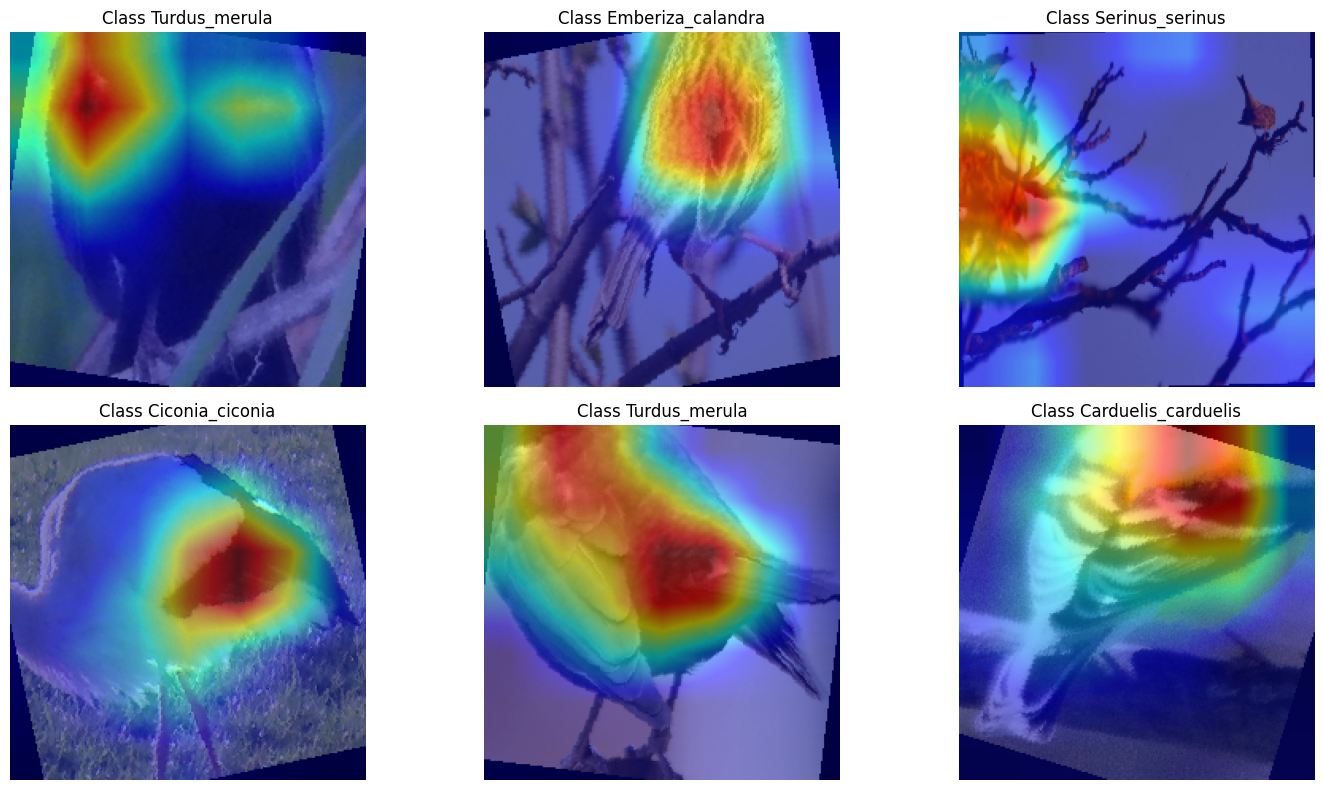

In [22]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Caminhos
h5_file = 'body_dataset_with_augmentation.h5'
model_path = 'saved_models/best_bird_body_model_11classes.pth'

# Carregar dados (já normalizados e em [C,H,W])
with h5py.File(h5_file, 'r') as hf:
    X = hf['X'][:]  # (N, 3, 224, 224), dtype=float32
    y = hf['y'][:]

# Desnormalizar para visualização (mesmo padrão do treino)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    if torch.is_tensor(img_tensor):
        img = img_tensor.cpu().numpy()
    else:
        img = img_tensor
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = np.clip(img, 0, 1)
    return np.transpose(img, (1, 2, 0))  # [C,H,W] → [H,W,C]

# Carregar modelo
model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 11)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# GradCAM
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Função para aplicar grad-cam
def apply_gradcam(img_tensor, class_idx):
    input_tensor = torch.tensor(img_tensor).unsqueeze(0)  # [1,3,224,224]
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(int(class_idx))])[0]
    img_rgb = denormalize(img_tensor)
    return show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)

# Plot de 6 exemplos aleatórios
indices = random.sample(range(len(X)), 6)
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

species_list = ['Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto', 'Emberiza_calandra',
                'Carduelis_carduelis', 'Serinus_serinus', 'Delichon_urbicum', 'Hirundo_rustica',
                'Passer_domesticus', 'Sturnus_unicolor', 'Turdus_merula']

for ax, idx in zip(axs.flat, indices):
    img = X[idx]
    label = y[idx]
    vis = apply_gradcam(img, label)
    ax.imshow(vis)
    ax.set_title(f"Class {species_list[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [2]:
from BirdClassifier import BirdClassifierEnsemble

In [3]:
classifier = BirdClassifierEnsemble()

cuda
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=Tru

In [3]:
classifier.classify("C://Users//boped//Downloads//900.jpg")


0: 480x640 1 bird_head, 1 bird_body, 58.1ms
Speed: 3.3ms preprocess, 58.1ms inference, 89.6ms postprocess per image at shape (1, 3, 480, 640)


[('Ciconia_ciconia', 0.6666666865348816),
 ('Columba_livia', 0.3333333432674408),
 ('Streptopelia_decaocto', 0.0)]

In [1]:
import os
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, top_k_accuracy_score
from tqdm import tqdm
import numpy as np

def evaluate_directory(classifier, root_dir, method='mean'):
    y_true = []
    y_pred = []
    y_prob = []

    species_to_index = {name: i for i, name in enumerate(classifier.species_list)}

    for species in classifier.species_list:
        class_dir = os.path.join(root_dir, species)
        if not os.path.isdir(class_dir):
            continue

        for filename in tqdm(os.listdir(class_dir), desc=f"Processing {species}"):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            path = os.path.join(class_dir, filename)

            try:
                result = classifier.classify(path, method=method)
                probs = np.zeros(len(classifier.species_list))
                for i, (label, prob) in enumerate(result):
                    idx = classifier.species_list.index(label)
                    probs[idx] = prob

                top1_label = result[0][0]
                y_true.append(species_to_index[species])
                y_pred.append(species_to_index[top1_label])
                y_prob.append(probs)
            except Exception as e:
                print(f"Error with {path}: {e}")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    macro_auprc = average_precision_score(np.eye(len(classifier.species_list))[y_true], y_prob, average='macro')
    top3_acc = top_k_accuracy_score(y_true, y_prob, k=3)

    return {
        "Macro-F1": macro_f1,
        "Accuracy": acc,
        "Macro-AUPRC": macro_auprc,
        "Top-3 Accuracy": top3_acc
    }


In [2]:
from BirdClassifier import BirdClassifierEnsemble

classifier = BirdClassifierEnsemble()
metrics = evaluate_directory(classifier, "full_image_dataset//", method="mean")

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

cuda


Processing Ciconia_ciconia:   0%|                                                              | 0/592 [00:00<?, ?it/s]


0: 640x640 1 bird_head, 1 bird_body, 16.8ms
Speed: 32.5ms preprocess, 16.8ms inference, 546.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Ciconia_ciconia:   0%|                                                      | 1/592 [00:04<47:20,  4.81s/it]

{'head': tensor([[9.9975e-01, 1.9547e-07, 1.9600e-05, 7.1358e-06, 5.0836e-08, 7.6680e-08, 4.9828e-06, 8.4083e-05, 6.4055e-07, 8.3611e-06, 1.2481e-04]], device='cuda:0'), 'body': tensor([[0.2222, 0.0194, 0.0196, 0.0130, 0.0013, 0.0056, 0.1556, 0.0021, 0.3251, 0.2139, 0.0220]], device='cuda:0'), 'multiclass': tensor([[0.1245, 0.0605, 0.0133, 0.0864, 0.0213, 0.0333, 0.0487, 0.2617, 0.0743, 0.1122, 0.1640]], device='cuda:0')}

0: 448x640 2 bird_bodys, 237.4ms
Speed: 7.5ms preprocess, 237.4ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)
{'body': tensor([[1.5552e-02, 8.6344e-03, 1.0215e-03, 4.8220e-05, 2.5040e-04, 8.8040e-05, 7.7994e-04, 9.7293e-01, 3.1956e-04, 2.8918e-04, 8.2107e-05]], device='cuda:0'), 'multiclass': tensor([[0.0057, 0.9491, 0.0023, 0.0108, 0.0033, 0.0163, 0.0011, 0.0025, 0.0051, 0.0017, 0.0022]], device='cuda:0')}


Processing Ciconia_ciconia:   0%|▏                                                     | 2/592 [00:05<22:19,  2.27s/it]


0: 544x640 1 bird_head, 150.3ms
Speed: 10.5ms preprocess, 150.3ms inference, 7.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Ciconia_ciconia:   1%|▎                                                     | 3/592 [00:05<14:48,  1.51s/it]

{'head': tensor([[9.9880e-01, 1.1675e-05, 3.0648e-06, 1.9556e-06, 3.7716e-06, 2.3536e-07, 3.8053e-06, 2.5919e-05, 6.8133e-06, 1.7015e-05, 1.1226e-03]], device='cuda:0'), 'multiclass': tensor([[0.0642, 0.1902, 0.1657, 0.0618, 0.0654, 0.0319, 0.0151, 0.0285, 0.2820, 0.0722, 0.0229]], device='cuda:0')}

0: 640x384 (no detections), 189.2ms
Speed: 4.1ms preprocess, 189.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)
{'multiclass': tensor([[0.0057, 0.0358, 0.1881, 0.0055, 0.0167, 0.0721, 0.0695, 0.0115, 0.1133, 0.0374, 0.4445]], device='cuda:0')}


Processing Ciconia_ciconia:   1%|▎                                                     | 4/592 [00:06<10:59,  1.12s/it]


0: 640x384 1 bird_head, 1 bird_body, 29.4ms
Speed: 4.9ms preprocess, 29.4ms inference, 19.2ms postprocess per image at shape (1, 3, 640, 384)


Processing Ciconia_ciconia:   1%|▍                                                     | 5/592 [00:06<08:36,  1.14it/s]

{'head': tensor([[9.9999e-01, 5.3356e-07, 5.2129e-08, 4.1363e-07, 8.7102e-08, 9.0141e-08, 1.3024e-07, 1.5159e-06, 4.9291e-07, 1.4862e-06, 2.4756e-06]], device='cuda:0'), 'body': tensor([[4.9270e-02, 2.4317e-03, 2.4304e-03, 1.6670e-01, 1.1961e-03, 1.1340e-04, 8.5985e-04, 9.4716e-05, 3.9097e-03, 9.4185e-03, 7.6357e-01]], device='cuda:0'), 'multiclass': tensor([[0.0116, 0.6398, 0.1649, 0.0097, 0.0056, 0.0287, 0.0407, 0.0029, 0.0116, 0.0783, 0.0061]], device='cuda:0')}

0: 448x640 1 bird_head, 3 bird_bodys, 39.3ms
Speed: 4.9ms preprocess, 39.3ms inference, 14.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Ciconia_ciconia:   1%|▌                                                     | 6/592 [00:07<07:10,  1.36it/s]

{'head': tensor([[9.9999e-01, 5.4798e-07, 1.6679e-07, 1.3525e-06, 9.1764e-08, 9.5521e-08, 3.3089e-08, 2.8590e-07, 2.2663e-06, 5.5293e-06, 1.6935e-08]], device='cuda:0'), 'body': tensor([[8.4479e-01, 6.7312e-03, 4.7297e-02, 2.7031e-03, 2.8853e-03, 1.1002e-03, 4.3370e-03, 7.3785e-04, 1.3007e-03, 7.8600e-02, 9.5212e-03]], device='cuda:0'), 'multiclass': tensor([[5.0015e-03, 9.6388e-01, 9.3854e-04, 1.5180e-03, 2.1707e-03, 8.1277e-03, 2.3273e-03, 1.4389e-03, 3.3758e-03, 6.1289e-03, 5.0938e-03]], device='cuda:0')}

0: 448x640 2 bird_heads, 35.2ms
Speed: 2.5ms preprocess, 35.2ms inference, 19.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Ciconia_ciconia:   1%|▋                                                     | 7/592 [00:07<06:17,  1.55it/s]

{'head': tensor([[1.0000e+00, 4.4928e-08, 2.2557e-09, 3.1823e-08, 1.9765e-09, 1.2842e-09, 6.3041e-10, 4.0994e-09, 6.9941e-08, 2.4186e-07, 1.5116e-09]], device='cuda:0'), 'multiclass': tensor([[0.0511, 0.0660, 0.0558, 0.1929, 0.1097, 0.1201, 0.0204, 0.1040, 0.0634, 0.1875, 0.0292]], device='cuda:0')}

0: 480x640 2 bird_bodys, 178.5ms
Speed: 8.0ms preprocess, 178.5ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Ciconia_ciconia:   1%|▋                                                     | 7/592 [00:08<11:26,  1.17s/it]

KeyboardInterrupt



In [5]:
import torch 
print(torch.load("saved_models//full_image_model//final_model_20250523.pth", map_location='cuda'))


{'model_state_dict': OrderedDict({'features.0.0.weight': tensor([[[[-5.4354e-01, -3.7211e-02,  6.3138e-01],
          [-1.0393e+00, -1.3069e-01,  1.2489e+00],
          [-1.0814e+00, -1.8500e-01,  1.1335e+00]],

         [[-8.5834e-01, -1.1459e-01,  8.6320e-01],
          [-1.4367e+00, -1.9218e-01,  1.6727e+00],
          [-1.4091e+00, -1.5903e-01,  1.6047e+00]],

         [[-2.8974e-01, -6.0413e-02,  3.3568e-01],
          [-6.4670e-01, -3.3325e-02,  9.3541e-01],
          [-7.2574e-01, -2.2053e-01,  7.5364e-01]]],


        [[[ 8.9812e-02,  8.1855e-02, -8.0183e-02],
          [ 1.7107e-01, -3.9782e-02, -1.3917e-01],
          [ 1.1312e-01, -3.9478e-02, -1.8814e-01]],

         [[-2.8546e-02, -3.3852e-01, -2.9526e-01],
          [-3.6071e-01, -7.0234e-01, -5.3877e-01],
          [-2.7189e-01, -5.0204e-01, -4.9735e-01]],

         [[-6.7896e-03,  2.7510e-01,  3.0317e-01],
          [ 1.5393e-01,  8.0175e-01,  8.4210e-01],
          [ 3.4249e-02,  6.6708e-01,  6.2111e-01]]],


        [

In [7]:
import h5py
import torch

with h5py.File('full_image_dataset//dataset_20250523_165448.h5', 'r') as hf:
    print(hf)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'full_image_dataset//dataset_20250523_165448.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)